In [1]:
import signac
import numpy as np
import matplotlib.pyplot as plt
import cmeutils
import matplotlib.cm as cm
import scienceplots
import gsd.hoomd
#plt.style.use('science')

# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

In [8]:
project = signac.get_project("../pps-flow/")
done = [j.doc.done for j in project]
print("Done:", done.count(True), "Not Done:", done.count(False))

Done: 32 Not Done: 20


In [9]:
for job in project.find_jobs(doc_filter={"done": True}):
    try:
        job.doc.N
    except:
        with gsd.hoomd.open(job.fn("trajectory.gsd")) as traj:
            job.doc.N = traj[0].particles.N

# Pressure vs Density:

Text(0, 0.5, 'Pressure (Reduced)')

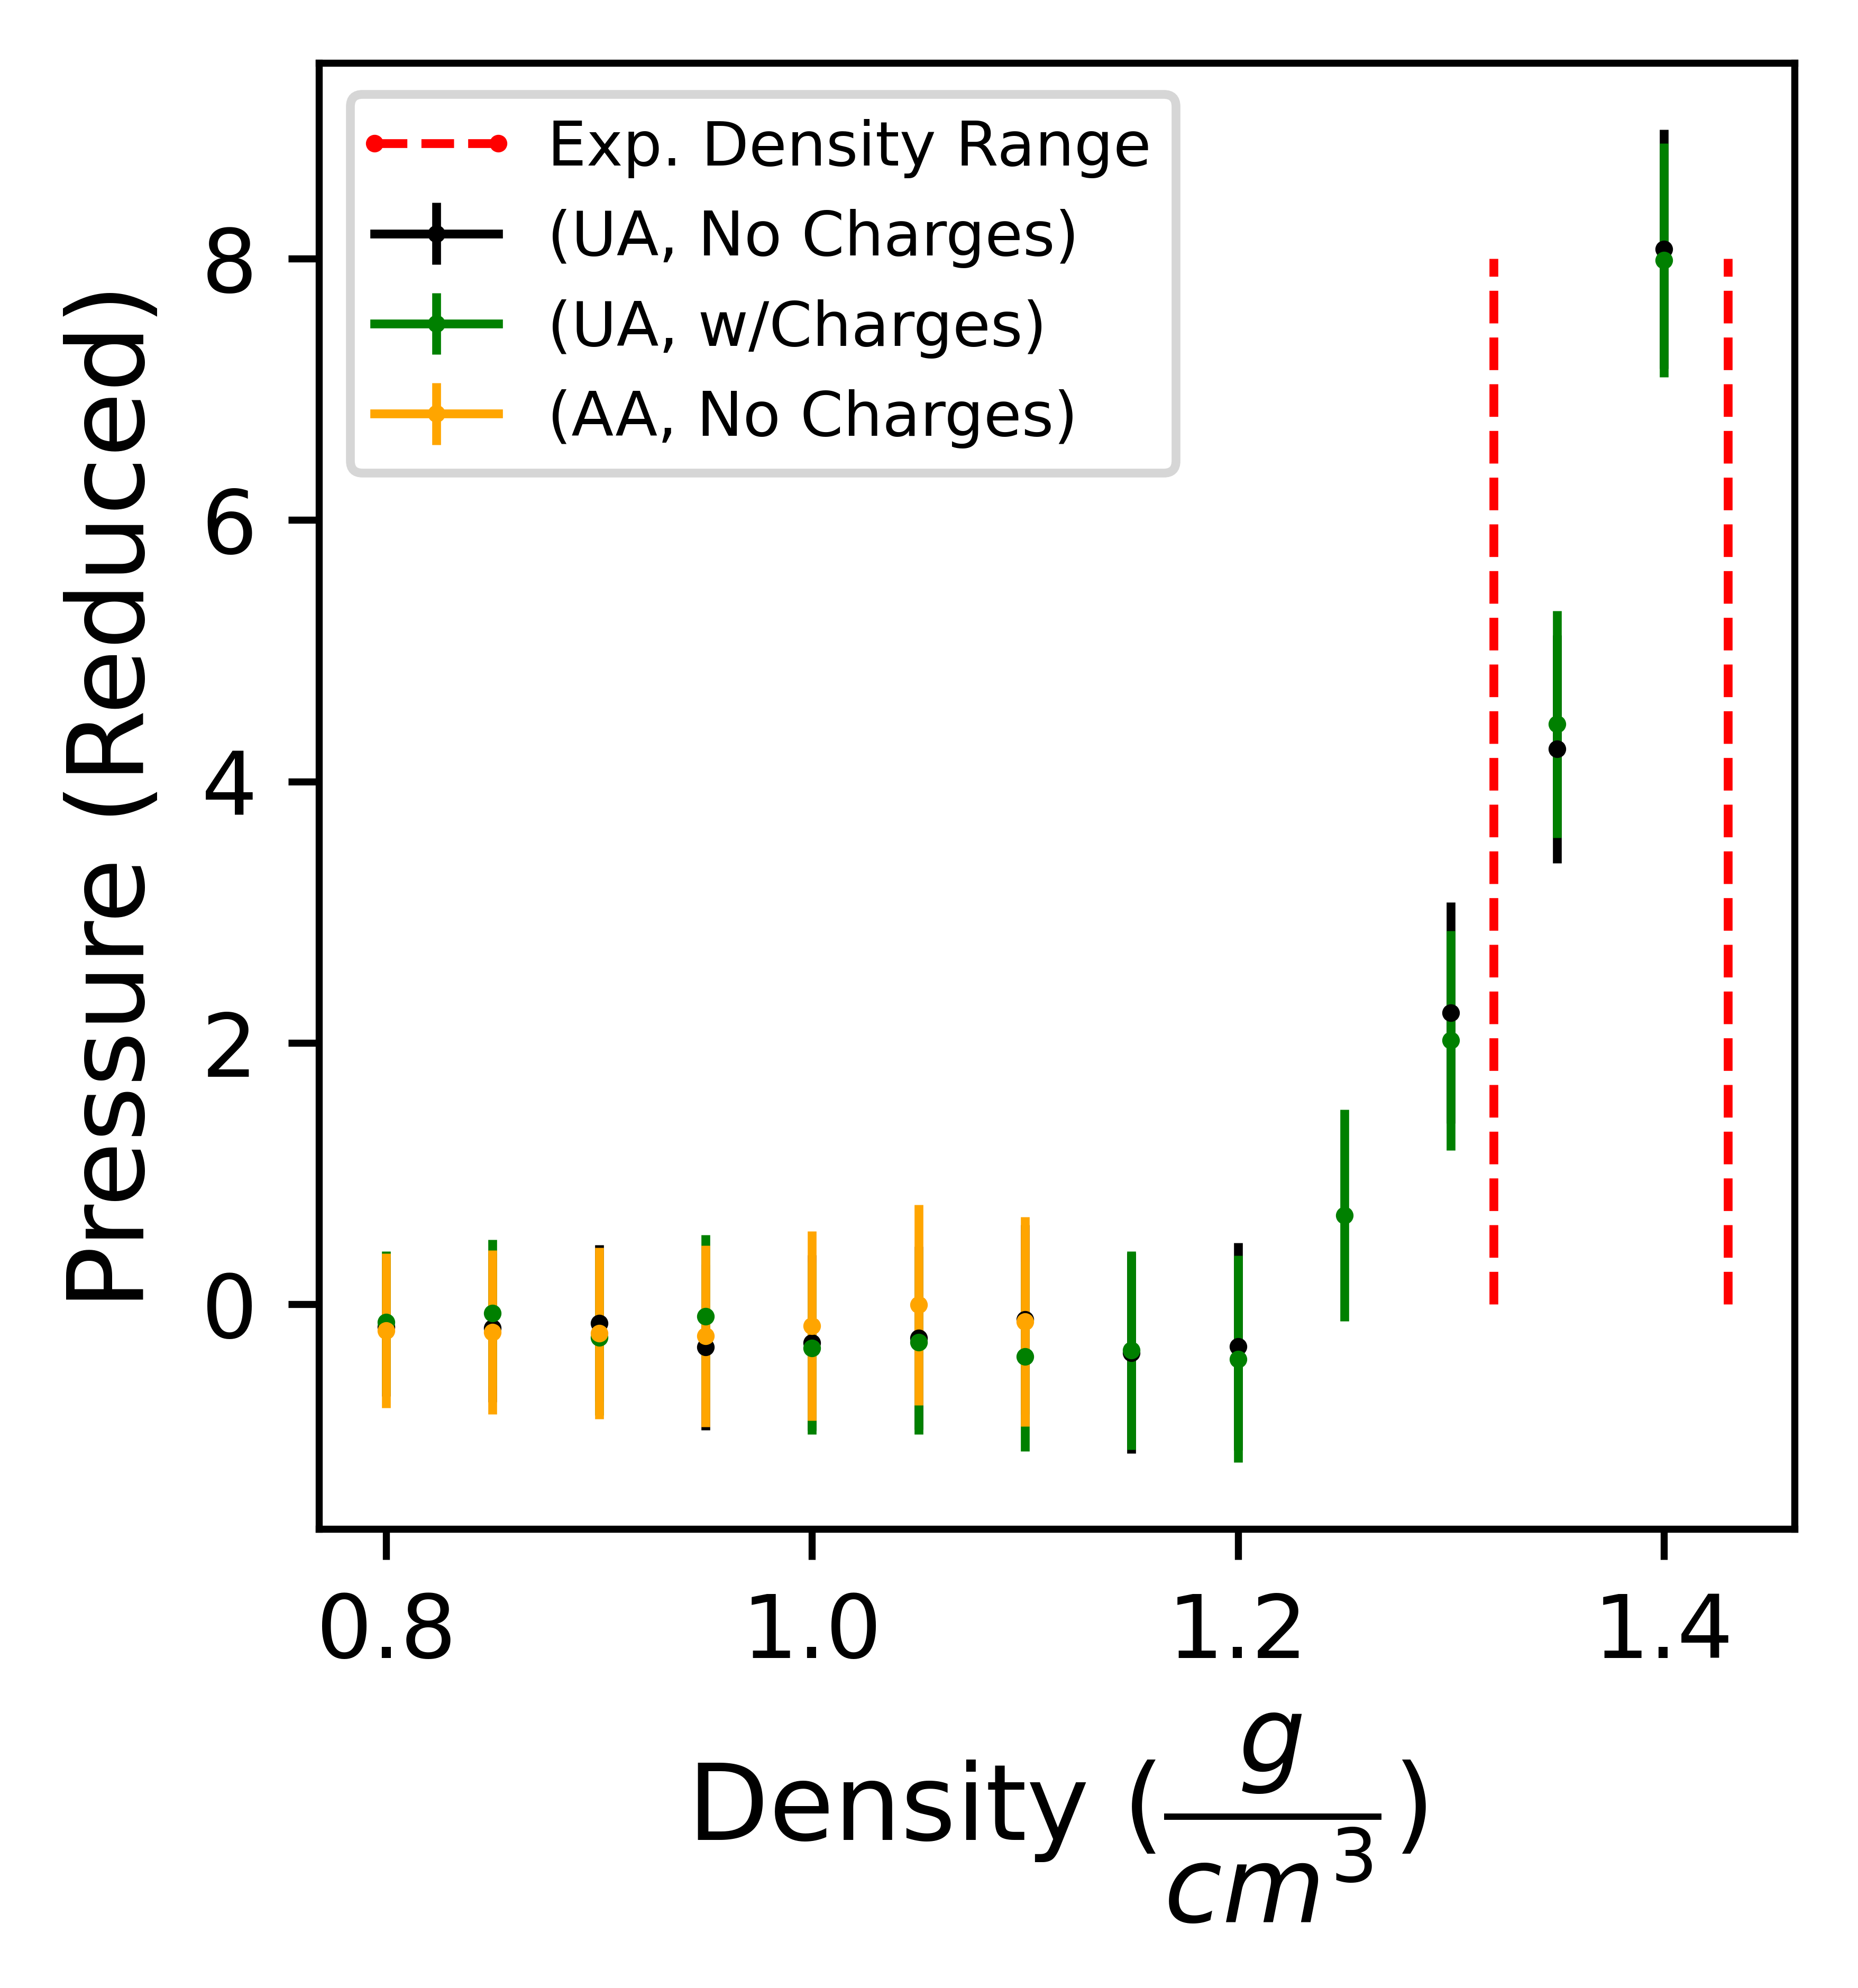

In [14]:
fig = plt.figure()
for den, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc.average_pressure, yerr=job.doc.pressure_std, marker="o", c="k", label="(UA, No Charges)"
    )
    
for den, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": True}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc.average_pressure, yerr=job.doc.pressure_std, marker="o", c="g", label="(UA, w/Charges)"
    )
    
for den, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": False}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc.average_pressure, yerr=job.doc.pressure_std, marker="o", c="blue", label="(AA, w/Charges)"
    )

for den, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": False}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc.average_pressure, yerr=job.doc.pressure_std, marker="o", c="orange", label="(AA, No Charges)"
    )

    plt.vlines(x=1.32, ymin=0, ymax=8, label="Exp. Density Range", ls="--", color="r")
plt.vlines(x=1.43, ymin=0, ymax=8, label="Exp. Density Range", ls="--", color="r")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel("Density $(\dfrac{g}{cm^3})$")
plt.ylabel("Pressure (Reduced)")

# Potential Energies:

Text(0, 0.5, '<PE> (per particle)')

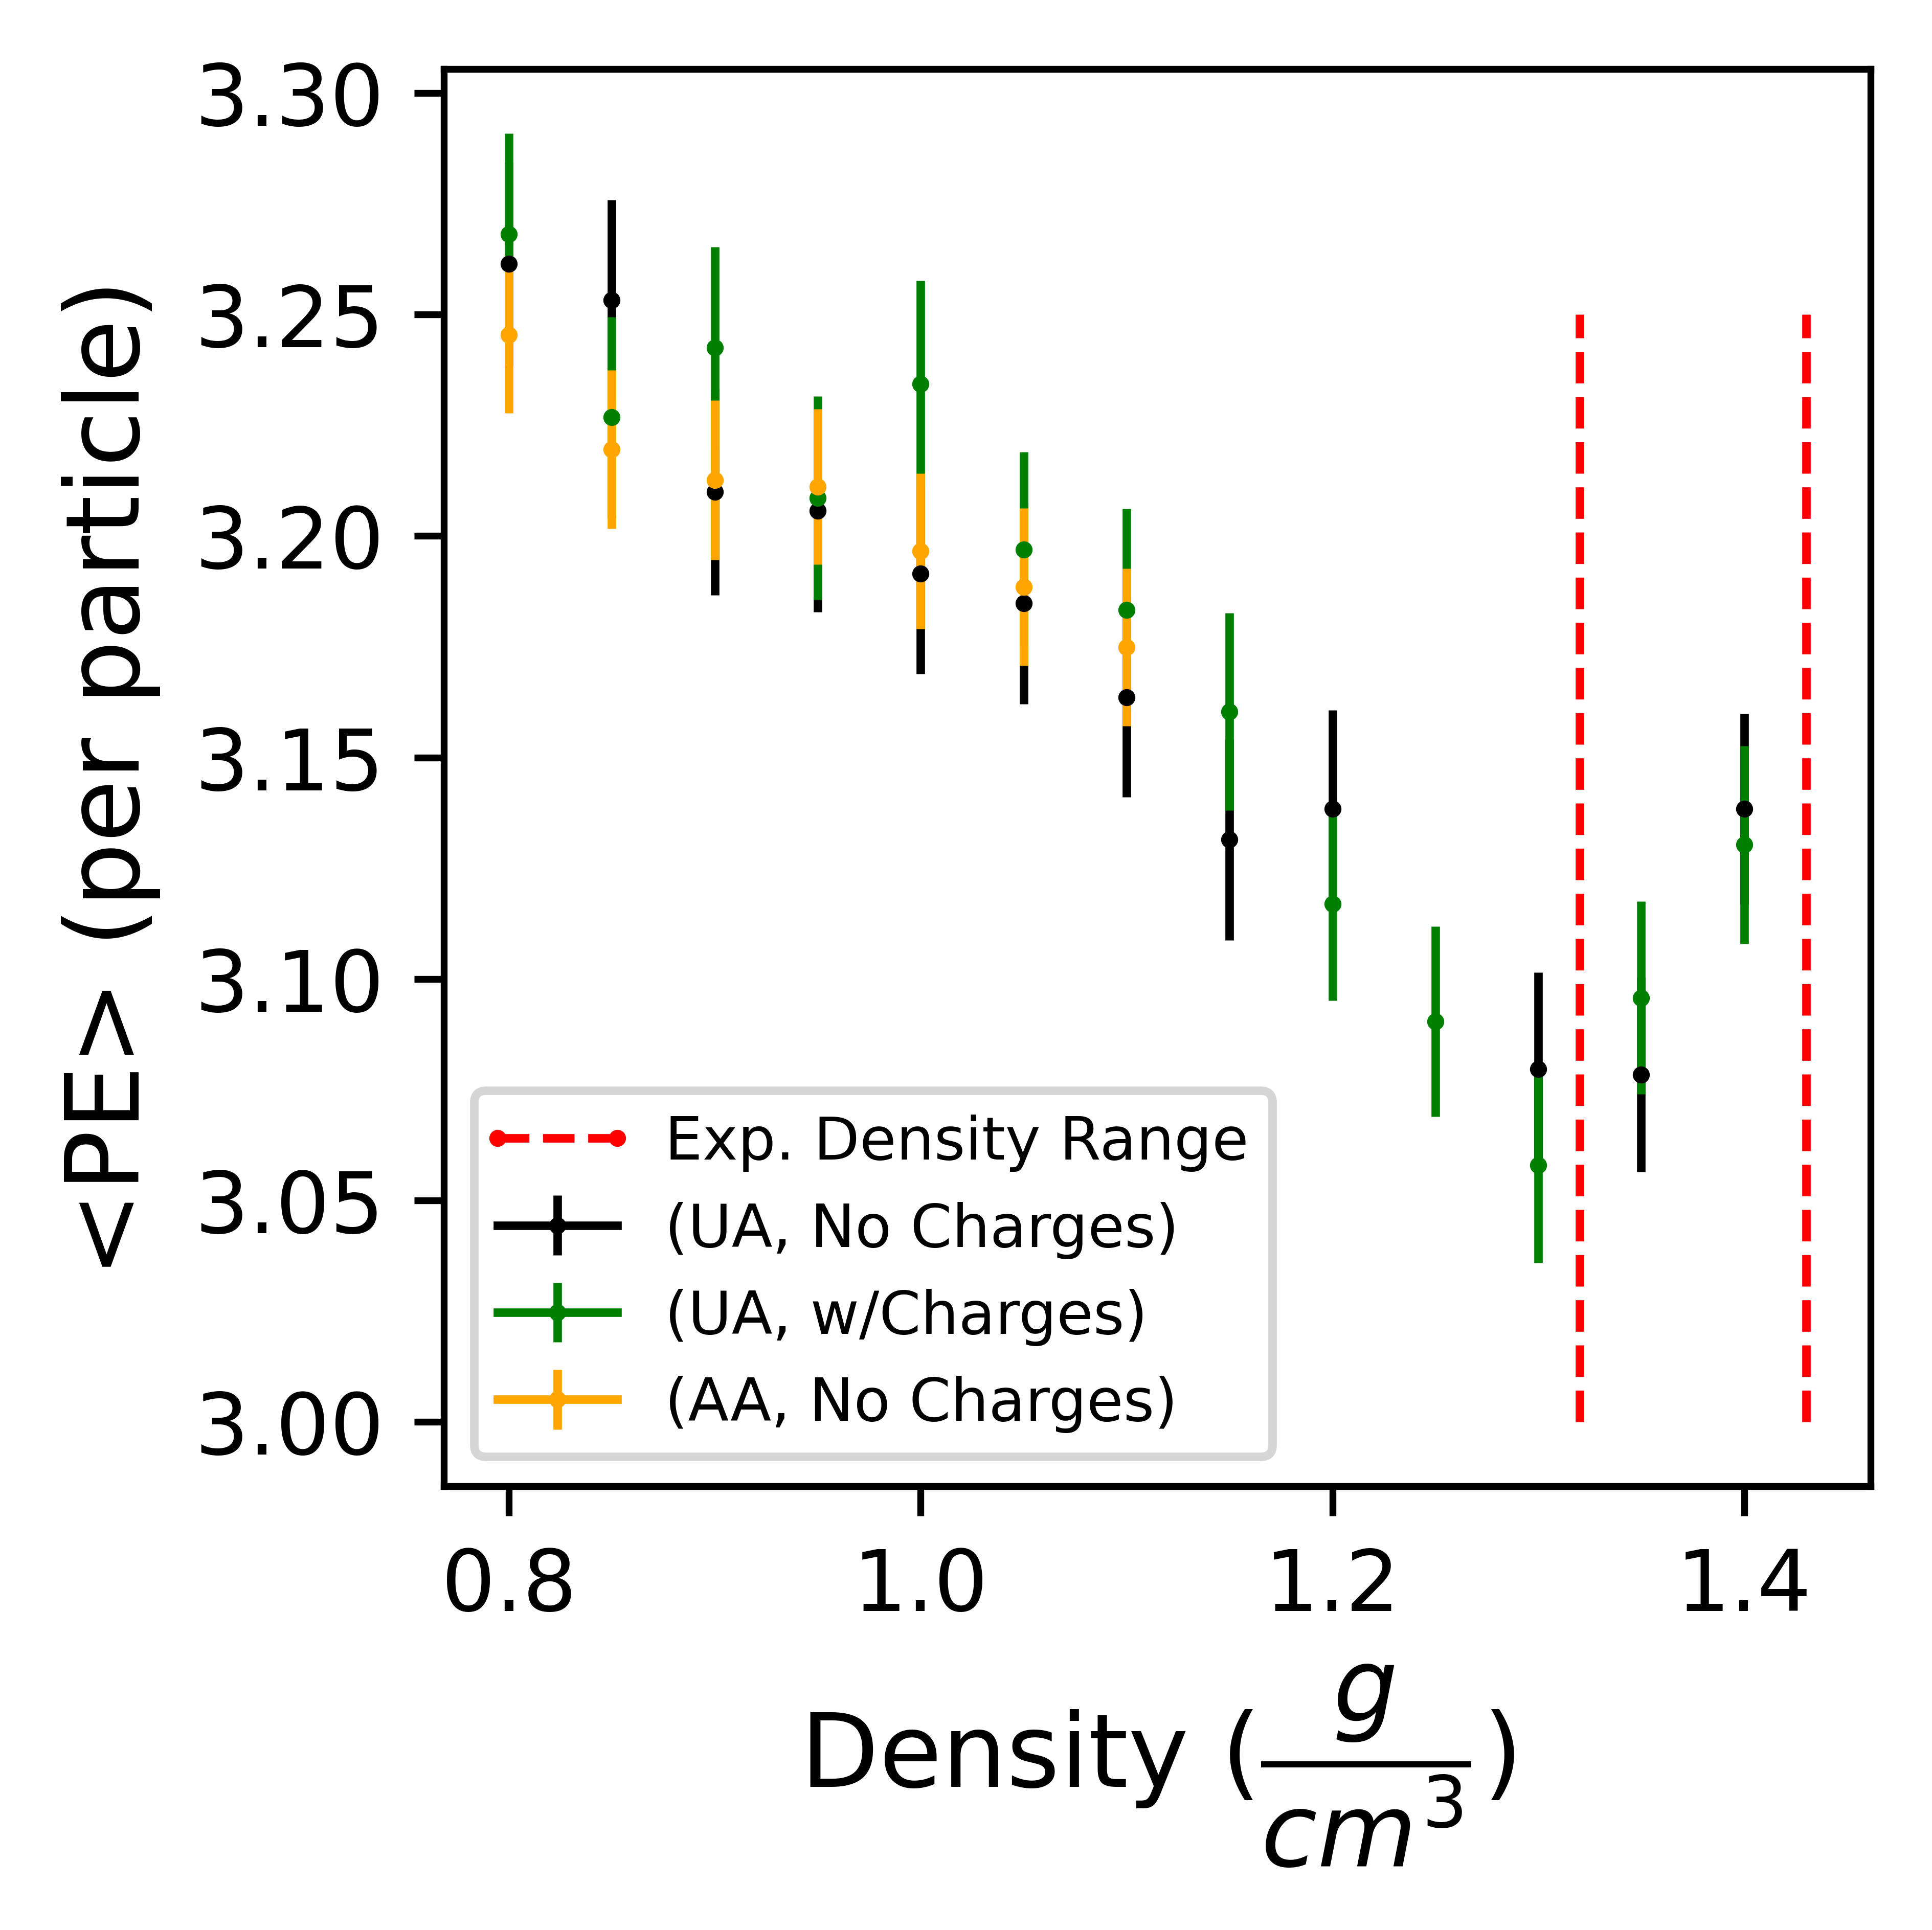

In [19]:
fig = plt.figure()
y = "average_pe"
err = "pe_std"
for den, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": True}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="k", label="(UA, No Charges)"
    )
    
for den, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": True}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="g", label="(UA, w/Charges)"
    )
    
for den, job in project.find_jobs(
    {"remove_charges": False, "remove_hydrogens": False}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="blue", label="(AA, w/Charges)"
    )

for den, job in project.find_jobs(
    {"remove_charges": True, "remove_hydrogens": False}, doc_filter={"done": True}).groupby("density"):
    job = list(job)[0]
    plt.errorbar(
        x=den, y=job.doc[y]/job.doc.N, yerr=job.doc[err]/job.doc.N, marker="o", c="orange", label="(AA, No Charges)"
    )
    
plt.vlines(x=1.32, ymin=3, ymax=3.25, label="Exp. Density Range", ls="--", color="r")
plt.vlines(x=1.43, ymin=3, ymax=3.25, label="Exp. Density Range", ls="--", color="r")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left")
plt.xlabel("Density $(\dfrac{g}{cm^3})$")
plt.ylabel("<PE> (per particle)")

# RDFs:

In [ ]:
color_dict = {
    (True, True): "k",
    (True, False): "b",
    (False, False): "g",
    (False, True): "orange",
}
densities = [0.8, 0.85, 0.95, 1.0, 0.9, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4]

for den in densities:
    fig = plt.figure()
    for job in project.find_jobs({"density": den}, {"done": True}):
        rdf, N = cmeutils.structure.gsd_rdf(
            gsdfile=job.fn("trajectory.gsd"),
            A_name="s",
            B_name="s",
            start=-50,
            stop=-1,
            exclude_bonded=True,
            r_max=3.0
        )
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        c = color_dict[label]
        plt.plot(rdf.bin_centers, rdf.rdf*N, label=label, c=color_dict[label])
        
    plt.legend(title=("(No H, No Charges)"))
    plt.title(f"Density: {den} g/cm^3")
    plt.xlabel("r ($\sigma$)")
    plt.ylabel("g(r)")
    plt.show()

In [ ]:
n_colors = len(densities)
gradient = cm.get_cmap('plasma', n_colors)
newcolors = gradient(np.linspace(0, 1, n_colors))

for combo in [(True, True), (True, False), (False, False), (False, True)]:
    fig = plt.figure()
    count = 0
    for den, job in project.find_jobs(
        {"remove_hydrogens": combo[0], "remove_charges": combo[1]}, {"done": True}).groupby("density"):
        job = list(job)[0]
        rdf, N = cmeutils.structure.gsd_rdf(
            gsdfile=job.fn("trajectory.gsd"),
            A_name="s",
            B_name="s",
            start=-50,
            stop=-1,
            exclude_bonded=True,
            r_max=3.0
        )
        plt.plot(rdf.bin_centers, rdf.rdf*N, label=den, c=newcolors[count])
        count += 1
        
    plt.title((f"Remove H: {combo[0]}, Remove Charges: {combo[1]}"))
    plt.legend(title="Den.")
    plt.xlabel("r ($\sigma$)")
    plt.ylabel("g(r)")
    plt.show()

In [ ]:
job.doc

In [ ]:
fig = plt.figure()

for den in densities:
    for job in project.find_jobs({"density": den}, {"done": True}):
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        plt.plot(den, job.doc.total_time*1e-6, c=color_dict[label], label=label, marker="o")
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title=("(Remove H, Remove Charges)"),
    loc=(1.1, 0.5)
)
plt.title("Time to Equilibration")
plt.xlabel("Density")
plt.ylabel("Time (ns)")
plt.show()

In [ ]:
fig = plt.figure()

for den in densities:
    for job in project.find_jobs({"density": den}, {"done": True}):
        label = (job.sp.remove_hydrogens, job.sp.remove_charges)
        plt.plot(den, job.doc.total_time*1e-6, c=color_dict[label], label=label, marker="o")
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    title=("(Remove H, Remove Charges)"),
    loc=(1.1, 0.5)
)
plt.title("Time to Equilibration")
plt.xlabel("Density")
plt.ylabel("Time (ns)")
plt.show()